# Step #1 Loading the Data

In [1]:
# Remote data access for pandas
import pandas_datareader as webreader
# Mathematical functions 
import math 
# Fundamental package for scientific computing with Python
import numpy as np 
# Additional functions for analysing and manipulating data
import pandas as pd 
# Date Functions
from datetime import date, timedelta, datetime
# This function adds plotting functions for calender dates
from pandas.plotting import register_matplotlib_converters
# Important package for visualization - we use this to plot the market data
import matplotlib.pyplot as plt 
# Formatting dates
import matplotlib.dates as mdates
# Packages for measuring model performance / errors
from sklearn.metrics import mean_absolute_error, mean_squared_error
# Deep learning library, used for neural networks
from keras.models import Sequential 
# Deep learning classes for recurrent and regular densely-connected layers
from keras.layers import LSTM, Dense, Dropout
# EarlyStopping during model training
from keras.callbacks import EarlyStopping
# This Scaler removes the median and scales the data according to the quantile range to normalize the price data 
from sklearn.preprocessing import RobustScaler

# Setting the timeframe for the data extraction
today = date.today()
date_today = today.strftime("%Y-%m-%d")
date_start = '2010-01-01'

# Getting NASDAQ quotes
stockname = 'NASDAQ'
symbol = '^IXIC'
df = webreader.DataReader(
    symbol, start=date_start, end=date_today, data_source="yahoo"
)

# Create a quick overview of the dataset
train_dfs = df.copy()
train_dfs

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2010-01-04,2311.149902,2294.409912,2294.409912,2308.419922,1931380000,2308.419922
2010-01-05,2313.729980,2295.620117,2307.270020,2308.709961,2367860000,2308.709961
2010-01-06,2314.070068,2295.679932,2307.709961,2301.090088,2253340000,2301.090088
2010-01-07,2301.300049,2285.219971,2298.090088,2300.050049,2270050000,2300.050049
2010-01-08,2317.600098,2290.610107,2292.239990,2317.169922,2145390000,2317.169922
...,...,...,...,...,...,...
2021-06-14,14175.450195,14056.669922,14083.469727,14174.139648,4394380000,14174.139648
2021-06-15,14171.019531,14052.160156,14166.639648,14072.860352,4517770000,14072.860352
2021-06-16,14129.690430,13903.730469,14085.549805,14039.679688,4632480000,14039.679688


# Step #2 Exploring the Data

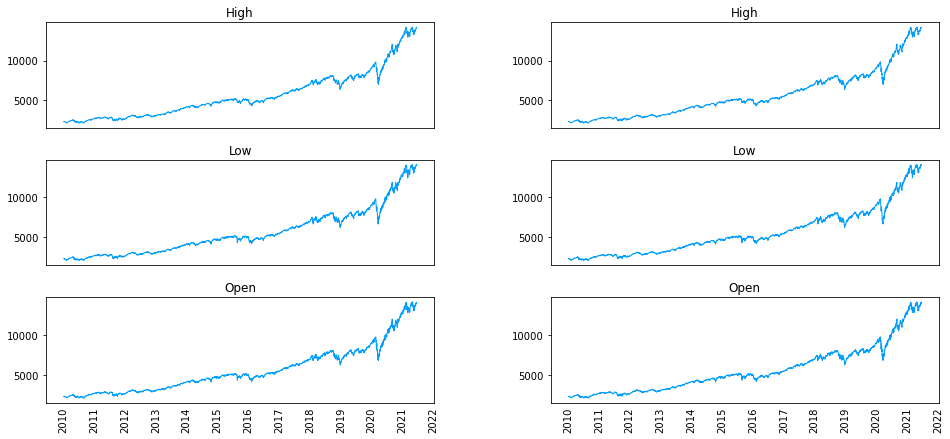

In [2]:
# Plot each column
register_matplotlib_converters()
nrows = 3
ncols = int(round(train_dfs.shape[1] / nrows, 0))
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, figsize=(16, 7))
fig.subplots_adjust(hspace=0.3, wspace=0.3)
x = train_dfs.index

for f, i in enumerate(range(nrows)):
    for j in range(ncols):
        ax[i, j].xaxis.set_major_locator(mdates.YearLocator())
        assetname = train_dfs.columns[f]
        y = train_dfs[assetname]
        ax[i, j].plot(x, y, color='#039dfc', label=stockname, linewidth=1.0)
        ax[i, j].set_title(assetname)
        ax[i, j].tick_params(axis="x", rotation=90, labelsize=10, length=0)   
#plt.show()

# Step #3 Preprocessing and Feature Selection

In [3]:
# Indexing Batches
train_df = train_dfs.sort_values(by=['Date']).copy()

# We safe a copy of the dates index, before we need to reset it to numbers
date_index = train_df.index

# Adding Month and Year in separate columns
d = pd.to_datetime(train_df.index)
train_df['Month'] = d.strftime("%m")
train_df['Year'] = d.strftime("%Y") 

# We reset the index, so we can convert the date-index to a number-index
train_df = train_df.reset_index(drop=True).copy()
train_df.head(5)

,High,Low,Open,Close,Volume,Adj Close,Month,Year
0,2311.149902,2294.409912,2294.409912,2308.419922,1931380000,2308.419922,01,2010
1,2313.729980,2295.620117,2307.270020,2308.709961,2367860000,2308.709961,01,2010
2,2314.070068,2295.679932,2307.709961,2301.090088,2253340000,2301.090088,01,2010
3,2301.300049,2285.219971,2298.090088,2300.050049,2270050000,2300.050049,01,2010
4,2317.600098,2290.610107,2292.239990,2317.169922,2145390000,2317.169922,01,2010


In [4]:
# List of considered Features
FEATURES = ['High', 'Low', 'Open', 'Close', 'Volume', 'Month'
            #'Year',
            #'Adj Close'
           ]

print('FEATURE LIST')
print([f for f in FEATURES])

# Create the dataset with features and filter the data to the list of FEATURES
data = pd.DataFrame(train_df)
data_filtered = data[FEATURES]

# We add a prediction column and set dummy values to prepare the data for scaling
data_filtered_ext = data_filtered.copy()
data_filtered_ext['Prediction'] = data_filtered_ext['Close']

# Print the tail of the dataframe
data_filtered_ext.tail()

FEATURE LIST
['High', 'Low', 'Open', 'Close', 'Volume', 'Month']


,High,Low,Open,Close,Volume,Month,Prediction
2880,14175.450195,14056.669922,14083.469727,14174.139648,4394380000,06,14174.139648
2881,14171.019531,14052.160156,14166.639648,14072.860352,4517770000,06,14072.860352
2882,14129.690430,13903.730469,14085.549805,14039.679688,4632480000,06,14039.679688
2883,14196.209961,13998.929688,13999.129883,14161.349609,4526780000,06,14161.349609
2884,14129.219727,14009.040039,14096.929688,14030.379883,6105960000,06,14030.379883


In [5]:
# Get the number of rows in the data
nrows = data_filtered.shape[0]

# Convert the data to numpy values
np_data_unscaled = np.array(data_filtered)
np_data = np.reshape(np_data_unscaled, (nrows, -1))
print(np_data.shape)

# Transform the data by scaling each feature to a range between 0 and 1
scaler = RobustScaler()
np_data = scaler.fit_transform(np_data_unscaled)

# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = RobustScaler()
df_Close = pd.DataFrame(data_filtered_ext['Close'])
np_Close_scaled = scaler_pred.fit_transform(df_Close)

(2885, 6)


In [6]:
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 50 # = number of neurons in the first layer of the neural network

# Prediction Index
index_Close = 0

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_len = math.ceil(np_data.shape[0] * 0.8)

# Create the training and test data
train_data = np_data[0:train_data_len, :]
test_data = np_data[train_data_len - sequence_length:, :]

# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_Close]) #contains the prediction values for validation (3rd column = Close),  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

(2258, 50, 6) (2258,)
(577, 50, 6) (577,)
-0.5810186640316026
-0.5810186640316026


# Step #4 Model Training

In [7]:
# Configure the neural network model
model = Sequential()

# Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
#model.add(Dropout(0.1))
model.add(LSTM(n_neurons, return_sequences=True))
#model.add(Dropout(0.1))
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(32))
model.add(Dense(1, activation='relu'))

# Compile the model
model.compile(optimizer='adam', loss='mse')

300 50 6


In [14]:
# Training the model
epochs = 100
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
history = model.fit(x_train, y_train, 
                    batch_size=32, 
                    epochs=epochs,
                    validation_data=(x_test, y_test)
                   )
                    
                    #callbacks=[early_stop])

Epoch 1/100
10/71 [===>..........................] - ETA: 17s - loss: 0.1087

KeyboardInterrupt: 

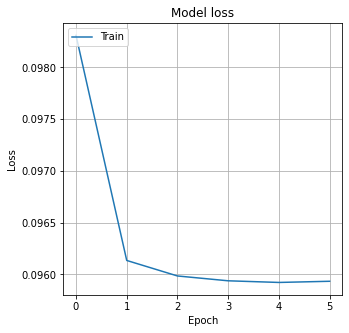

In [9]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(5, 5), sharex=True)
plt.plot(history.history["loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

# Step #5 Evaluate Model Performance

In [10]:
# Get the predicted values
predictions = model.predict(x_test)

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test, predictions)/ y_test))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test, predictions)/ y_test)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')

Mean Absolute Percentage Error (MAPE): 38.11 %
Median Absolute Percentage Error (MDAPE): 36.05 %


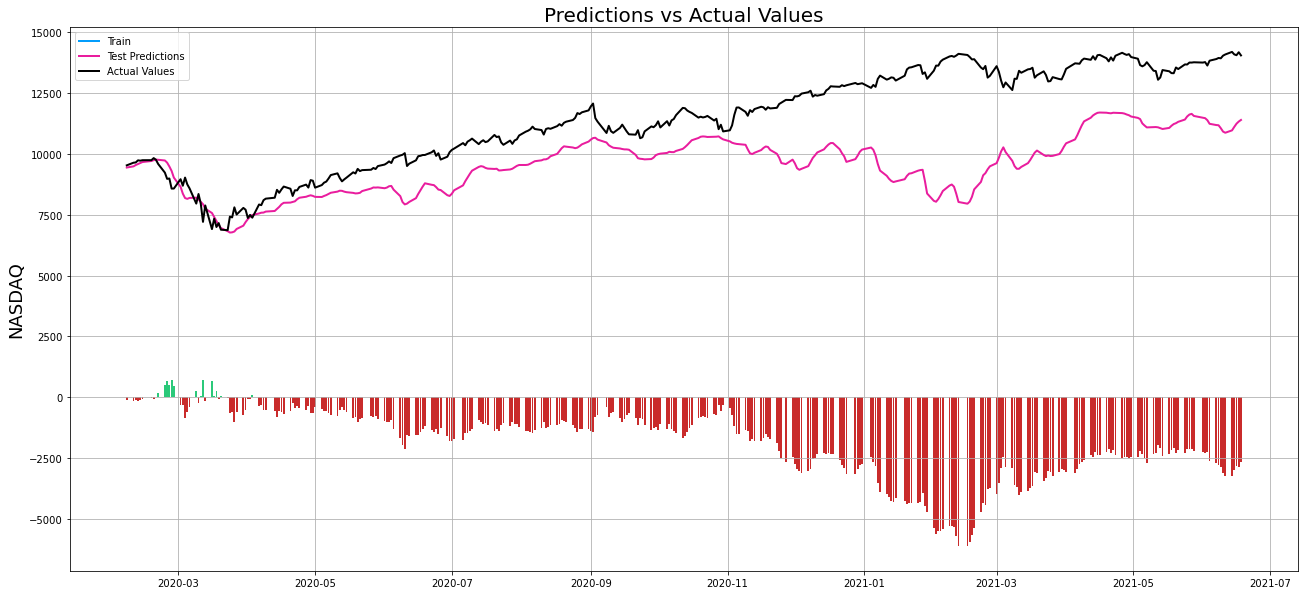

In [13]:
# Get the predicted values
pred_unscaled = scaler_pred.inverse_transform(predictions)

# The date from which on the date is displayed
display_start_date = pd.Timestamp('today') - timedelta(days=500)

# Add the date column
data_filtered_sub = data_filtered.copy()
data_filtered_sub['Date'] = date_index

# Add the difference between the valid and predicted prices
train = data_filtered_sub[:train_data_len + 1]
valid = data_filtered_sub[train_data_len:]
valid.insert(1, "Prediction", pred_unscaled.ravel(), True)
valid.insert(1, "Difference", valid["Prediction"] - valid["Close"], True)

# Zoom in to a closer timeframe
valid = valid[valid['Date'] > display_start_date]
train = train[train['Date'] > display_start_date]

# Visualize the data
fig, ax1 = plt.subplots(figsize=(22, 10), sharex=True)
xt = train['Date']; yt = train[["Close"]]
xv = valid['Date']; yv = valid[["Close", "Prediction"]]
plt.title("Predictions vs Actual Values", fontsize=20)
plt.ylabel(stockname, fontsize=18)
plt.plot(xt, yt, color="#039dfc", linewidth=2.0)
plt.plot(xv, yv["Prediction"], color="#E91D9E", linewidth=2.0)
plt.plot(xv, yv["Close"], color="black", linewidth=2.0)
plt.legend(["Train", "Test Predictions", "Actual Values"], loc="upper left")

# # Create the bar plot with the differences
x = valid['Date']
y = valid["Difference"]

# Create custom color range for positive and negative differences
valid.loc[y >= 0, 'diff_color'] = "#2BC97A"
valid.loc[y < 0, 'diff_color'] = "#C92B2B"

plt.bar(x, y, width=0.8, color=valid['diff_color'])
plt.grid()
plt.show()

# Step #6 Predict Next Day's Price

In [12]:
# Get fresh data until today and create a new dataframe with only the price data
date_start = date.today() - timedelta(days=200)
new_df = webreader.DataReader(symbol, data_source='yahoo', start=date_start, end=date_today)
d = pd.to_datetime(new_df.index)
new_df['Month'] = d.strftime("%m") 
new_df['Year'] = d.strftime("%Y") 
new_df = new_df.filter(FEATURES)

# Get the last 100 day closing price values and scale the data to be values between 0 and 1
last_100_days = new_df[-100:].values
last_100_days_scaled = scaler.transform(last_100_days)

# Create an empty list and Append past 100 days
X_test_new = []
X_test_new.append(last_100_days_scaled)

# Convert the X_test data set to a numpy array and reshape the data
pred_price_scaled = model.predict(np.array(X_test_new))
pred_price_unscaled = scaler_pred.inverse_transform(pred_price_scaled)

# Print last price and predicted price for the next day
price_today = round(new_df['Close'][-1], 2)
predicted_price = round(pred_price_unscaled.ravel()[0], 2)
percent = round(100 - (predicted_price * 100)/price_today, 2)

plus = '+'; minus = '-'
print(f'The close price for {stockname} at {today} was {price_today}')
print(f'The predicted close price is {predicted_price} ({plus if percent > 0 else minus}{percent}%)')

The close price for NASDAQ at 2021-06-20 was 14030.38
The predicted close price is 11255.7998046875 (+19.78%)
